## Configuration

In [1]:
import os
from itertools import chain

from sklearn.model_selection import GroupShuffleSplit

GRADIENT = os.path.exists('train')
KAGGLE = os.path.exists('../input')
model_name = 'squish-test-model.pkl'
SEED = 42
VAL_PCT = 0.2
INFER = True
DEBUG = True

## Libraries and Data

In [2]:
if KAGGLE:
    !cp -r ../input/pytorch-segmentation-models-lib/ ./
    !pip install -q ./pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
    !pip install -q ./pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
    !pip install -q ./pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
    !pip install -q ./pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [3]:
from fastai.vision.all import *

import gc

In [4]:
if KAGGLE:
    data_path = '../input/uw-madison-gi-tract-image-segmentation/'
    model_name = '../input/uw-madison-models/' + model_name
elif GRADIENT:
    data_path = ''
    model_name = 'kaggle-models/' + model_name 

In [5]:
path = Path(data_path+'train')
test_path = Path(data_path+'test')

train = pd.read_csv(data_path+'train.csv', low_memory=False)
sample_submission = pd.read_csv(data_path+'sample_submission.csv', low_memory=False).rename(columns={'predicted': 'segmentation'})

train_path = Path(data_path+'train')
test_path = Path(data_path+'test')

train_fnames = get_image_files(train_path)
test_fnames = get_image_files(test_path)

## Helper Functions

In [6]:
# Extract case id from fname
def get_case_id(fname):
    if KAGGLE: i = 5
    elif GRADIENT: i = 2
    return fname.parts[i] + '_' + fname.parts[i+2][:10]

def check_file(file_id, fname):
    case_id, day, _, slice_no = file_id.split('_')
    if case_id == fname.parts[1] and day == fname.parts[2].split('_')[1] and slice_no in fname.parts[-1]:
        return True
    return False

def get_file(file_id):
    return fnames.filter(lambda f: check_file(not_null_train.id[0], f))[0]

# https://www.kaggle.com/code/dschettler8845/uwm-gi-tract-image-segmentation-eda
def get_custom_df(df, fnames, root, channels=3, stride=1):    
    # 1. Get Case-ID as a column (str and int)
    df["case_id_str"] = df["id"].apply(lambda x: x.split("_", 2)[0])
    df["case_id"] = df["id"].apply(lambda x: int(x.split("_", 2)[0].replace("case", "")))

    # 2. Get Day as a column
    df["day_num_str"] = df["id"].apply(lambda x: x.split("_", 2)[1])
    df["day_num"] = df["id"].apply(lambda x: int(x.split("_", 2)[1].replace("day", "")))
    
    # Add case_day str column
    df["case_id_day_num_str"] = df["case_id_str"] + "_" + df["day_num_str"]

    # 3. Get Slice Identifier as a column
    df["slice_id"] = df["id"].apply(lambda x: x.split("_", 2)[2])

    # 4. Get full file paths for the representative scans
    df["_partial_fname"] = (root+'/'+ # /kaggle/input/uw-madison-gi-tract-image-segmentation/train/
                          df["case_id_str"]+"/"+ # .../case###/
                          df["case_id_str"]+"_"+df["day_num_str"]+ # .../case###_day##/
                          "/scans/"+df["slice_id"]) # .../slice_####
    
    _tmp_merge_df = pd.DataFrame({"_partial_fname":[str(x).rsplit("_",4)[0] for x in fnames], "fname": fnames})
    df = df.merge(_tmp_merge_df, on="_partial_fname").drop(columns=["_partial_fname"])
    
    # Minor cleanup of our temporary workaround
    del _tmp_merge_df; gc.collect(); gc.collect()
    
    # 5. Get slice dimensions from filepath (int in pixels)
    df["slice_h"] = df["fname"].apply(lambda x: int(str(x)[:-4].rsplit("_",4)[1]))
    df["slice_w"] = df["fname"].apply(lambda x: int(str(x)[:-4].rsplit("_",4)[2]))

    # 6. Pixel spacing from filepath (float in mm)
    df["px_spacing_h"] = df["fname"].apply(lambda x: float(str(x)[:-4].rsplit("_",4)[3]))
    df["px_spacing_w"] = df["fname"].apply(lambda x: float(str(x)[:-4].rsplit("_",4)[4]))

    # 7. Merge 3 Rows Into A Single Row (As This/Segmentation-RLE Is The Only Unique Information Across Those Rows)
    l_bowel_train_df = df[df["class"]=="large_bowel"][["id", "segmentation"]].rename(columns={"segmentation":"lb_seg_rle"})
    s_bowel_train_df = df[df["class"]=="small_bowel"][["id", "segmentation"]].rename(columns={"segmentation":"sb_seg_rle"})
    stomach_train_df = df[df["class"]=="stomach"][["id", "segmentation"]].rename(columns={"segmentation":"st_seg_rle"})
    df = df.merge(l_bowel_train_df, on="id", how="left")
    df = df.merge(s_bowel_train_df, on="id", how="left")
    df = df.merge(stomach_train_df, on="id", how="left")
    df = df.drop_duplicates(subset=["id",]).reset_index(drop=True)
    df["lb_seg_flag"] = df["lb_seg_rle"].apply(lambda x: not pd.isna(x))
    df["sb_seg_flag"] = df["sb_seg_rle"].apply(lambda x: not pd.isna(x))
    df["st_seg_flag"] = df["st_seg_rle"].apply(lambda x: not pd.isna(x))
    df["n_segs"] = df["lb_seg_flag"].astype(int)+df["sb_seg_flag"].astype(int)+df["st_seg_flag"].astype(int)
    
    df = df.sort_values(by=['id']).copy()
    
    # Add 2.5D fnames
    for j, i in enumerate(range(-1*(channels-channels//2-1), channels//2+1)):
        method = 'ffill'
        if i <= 0: method = 'bfill'
        df[f'fname_{j:02}'] = df.groupby(['case_id', 'day_num'])['fname'].shift(stride*-i).fillna(method=method)
        # df['fname_01'] = df.groupby(['case_id', 'day_num'])['fname'].shift(1*stride).fillna(method='bfill')
        # df['fname_02'] = df.groupby(['case_id', 'day_num'])['fname'].shift(0*stride).fillna(method='bfill')
        # df['fname_03'] = df.groupby(['case_id', 'day_num'])['fname'].shift(-1*stride).fillna(method='ffill')
        # df['fname_04'] = df.groupby(['case_id', 'day_num'])['fname'].shift(-2*stride).fillna(method='ffill')
    
    # for i in range(channels):
    #     df[f'fname_{i:02}'] = df.groupby(['case_id','day_num'])['fname'].shift(-i*stride).fillna(method="ffill")
    df['fnames'] = df[[f'fname_{j:02d}' for j in range(channels)]].values.tolist()

    # 8. Reorder columns to the a new ordering (drops class and segmentation as no longer necessary)
    df = df[["id", "fname", "fnames", "n_segs",
             "lb_seg_rle", "lb_seg_flag",
             "sb_seg_rle", "sb_seg_flag", 
             "st_seg_rle", "st_seg_flag",
             "slice_h", "slice_w", "px_spacing_h", 
             "px_spacing_w", "case_id_str", "case_id", 
             "day_num_str", "day_num", "case_id_day_num_str", "slice_id",]].reset_index(drop=True)
    

    return df

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
# modified from: https://www.kaggle.com/inversion/run-length-decoding-quick-start
def rle_decode(mask_rle, shape, color=1):
    """ TBD
    
    Args:
        mask_rle (str): run-length as string formated (start length)
        shape (tuple of ints): (height,width) of array to return 
    
    Returns: 
        Mask (np.array)
            - 1 indicating mask
            - 0 indicating background

    """
    # Split the string by space, then convert it into a integer array
    s = np.array(mask_rle.split(), dtype=int)

    # Every even value is the start, every odd value is the "run" length
    starts = s[0::2] - 1
    lengths = s[1::2]
    ends = starts + lengths

    # The image image is actually flattened since RLE is a 1D "run"
    if len(shape)==3:
        h, w, d = shape
        img = np.zeros((h * w, d), dtype=np.float32)
    else:
        h, w = shape
        img = np.zeros((h * w,), dtype=np.float32)

    # The color here is actually just any integer you want!
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
        
    # Don't forget to change the image back to the original shape
    return img.reshape(shape)

def get_image(row):
    img = np.array(Image.open(row['fname']))
    img = np.interp(img, [np.min(img), np.max(img)], [0,255])
    return img
    # return row['fname']
                   

def get_mask(row):
    mask = np.zeros((row['slice_w'], row['slice_h'], 3))
    if row['lb_seg_flag']:
        mask[..., 0] += rle_decode(row['lb_seg_rle'], shape=(row['slice_w'], row['slice_h']), color=255)
    if row['sb_seg_flag']:
        mask[..., 1] += rle_decode(row['sb_seg_rle'], shape=(row['slice_w'], row['slice_h']), color=255)
    if row['st_seg_flag']:
        mask[..., 2] += rle_decode(row['st_seg_rle'], shape=(row['slice_w'], row['slice_h']), color=255)
        
    return mask.astype(np.uint8)

def get_targs(row): return row[['lb_seg_flag', 'sb_seg_flag', 'st_seg_flag']].values.astype(np.uint8)

In [7]:
def add_custom_valid(train, val_pct):
    np.random.seed(SEED)

    cases = train.case_id.unique()
    n_cases = len(cases)
    random_cases = np.random.choice(cases, int(n_cases*val_pct/1.85), replace=False)

    train['is_valid'] = False
    train.loc[train.case_id.isin(random_cases), 'is_valid'] = True
    
    days = train.loc[~train['is_valid'], 'case_id_day_num_str'].unique()
    n_days = len(days)
    random_days = np.random.choice(days, int(n_days*val_pct/1.85), replace=False)

    train.loc[train.case_id_day_num_str.isin(random_days), 'is_valid'] = True
    
    return train

def add_group_valid(train, val_pct):
    gss = GroupShuffleSplit(n_splits=1, test_size=val_pct, random_state=SEED)
    train_idx, val_idx = [(train_idx, val_idx) for (train_idx, val_idx) in gss.split(train, train, train['case_id'])][0]

    train['is_valid'] = False
    train.loc[val_idx, 'is_valid'] = True

    return train

## Prepare Data

In [8]:
if sample_submission.shape[0] > 0: 
    test = sample_submission.copy()
else:
    test_fnames = train_fnames
    test_path = train_path
    test = train.copy()
    test = test.sample(frac=1.0, random_state=SEED)

# test = pd.DataFrame({
#     'id': chain.from_iterable([[get_case_id(fname)]*3 for fname in test_fnames]),
#     'class': chain.from_iterable([['large_bowel', 'small_bowel', 'stomach'] for _ in test_fnames]),
#     'segmentation': chain.from_iterable([[np.nan]*3 for _ in test_fnames]),
# })

test = get_custom_df(test, test_fnames, str(test_path))
train = get_custom_df(train, train_fnames, str(train_path))

## Use Datablock API

In [9]:
@ToTensor
def encodes(self, o:PILMask): return o._tensor_cls(image2tensor(o))

In [10]:
@Normalize
def encodes(self, o:TensorMask): return o / 255

@Normalize
def decodes(self, o:TensorMask): 
    f = to_cpu if o.device.type=='cpu' else noop
    return f((o * 255).long())

In [11]:
import matplotlib.patches as mpatches

@typedispatch
def show_batch(x:TensorImage, y:TensorMask, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*3, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(max_n, nrows=nrows, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        x_i = x[i] / x[i].max()
        show_image(x_i, ctx=ctx, cmap='gray', **kwargs)
        show_image(y[i], ctx=ctx, cmap='Spectral_r', alpha=0.35, **kwargs)
        red_patch = mpatches.Patch(color='red', label='lb')
        green_patch = mpatches.Patch(color='green', label='sb')
        blue_patch = mpatches.Patch(color='blue', label='st')
        ctx.legend(handles=[red_patch, green_patch, blue_patch], fontsize=figsize[0]/2)

In [12]:
def get_aug_dls(train, aug=[], img_size=224, method='squish', bs=16, sample=False, show=True, val='group'):
    batch_tfms = [Normalize.from_stats(*imagenet_stats)]
    if aug: batch_tfms = [*aug] + batch_tfms
    
    db = DataBlock((ImageBlock(cls=PILImageBW), MaskBlock),
                   get_x=get_image,
                   get_y=get_mask,
                   splitter = ColSplitter(),
                   item_tfms=[Resize(img_size, method=method)],
                   batch_tfms=batch_tfms)
    
    if val == 'group':
        train = add_group_valid(train)
    elif val == 'custom':
        train = add_custom_valid(train)
    
    if sample:
        dev = train.sample(frac=0.2, random_state=SEED)
    else:
        dev = train
        
    dls = db.dataloaders(dev, bs=bs, shuffle=True)
    dls.rng.seed(SEED)
    
    if show:
        dls.show_batch(nrows=bs//4, ncols=4, max_n=bs, figsize=(12, 12))
        
    return dls, dev

## Use midlevel API

In [13]:
# Class to show overlayed image with multi-channel mask
class MultiMaskImage(fastuple):
    def show(self, ctx=None, **kwargs): 
        if not ctx:
            ctx = plt.subplot()
        if len(self) == 2:
            img, case_id = self
        else:
            img, mask, case_id = self
            if not isinstance(mask, Tensor):
                t_mask = image2tensor(mask)
            else:
                t_mask = mask
        if not isinstance(img, Tensor):
            t_img = tensor(img)
        else:
            t_img = img
        
        show_image(t_img, ctx=ctx, cmap='gray', title=case_id, **kwargs)
        if len(self) > 2:
            show_image(t_mask, ctx=ctx, cmap='Spectral_r', alpha=0.35, **kwargs)


In [14]:
class MultiMaskTransform(Transform):
    def encodes(self, row):
        img = get_image(row)
        img = PILImageBW.create(img)
        case_id = row['id']
        mask = PILMask.create(get_mask(row))
        return MultiMaskImage(img, mask, case_id)

In [15]:
tfm = MultiMaskTransform()
x = tfm.encodes(train.iloc[74])
x

(PILImageBW mode=F size=266x266,
 PILMask mode=RGB size=266x266,
 'case101_day20_slice_0075')

In [16]:
@ToTensor
def encodes(self, o:PILMask): return o._tensor_cls(image2tensor(o))

@Normalize
def encodes(self, o:TensorMask): return o / 255

In [17]:
pipeline = Pipeline([Resize(224), ToTensor])

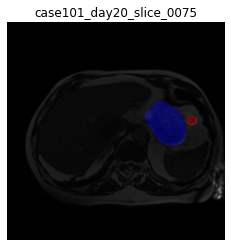

In [18]:
tfm.decodes(x).show()

### Sample dataset to test pipeline

### Don't forget to change this to train the whole dataset

In [22]:
if INFER:
    t = train.iloc[0:10]
elif SAMPLE:
    t = train.sample(frac=0.1, random_state=42)
else:
    t = train
    
splits = RandomSplitter(seed=42)(t)
tls = TfmdLists(t, tfm, splits=splits)

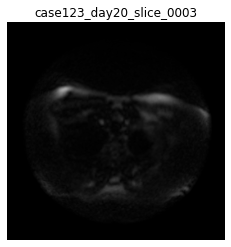

In [23]:
show_at(tls.valid, 0)

In [24]:
import matplotlib.patches as mpatches

@typedispatch
def show_batch(x:MultiMaskImage, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*3, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(x[0].shape[0]+1, nrows=nrows, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs[1:]): 
        MultiMaskImage(x[0][i], x[1][i], x[2][i]).show(ctx=ctx)
    red_patch = mpatches.Patch(color='red', label='large bowel')
    green_patch = mpatches.Patch(color='green', label='small bowel')
    blue_patch = mpatches.Patch(color='blue', label='stomach')
    ctxs[0].legend(handles=[red_patch, green_patch, blue_patch])
    ctxs[0].set_frame_on(False)
    ctxs[0].set_xticks([])
    ctxs[0].set_yticks([])

In [25]:
dls = tls.dataloaders(after_item=[Resize(128), ToTensor],
                      after_batch=[*aug_transforms(), IntToFloatTensor, Normalize.from_stats(*imagenet_stats)], bs=8, shuffle=True)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [26]:
from tqdm import tqdm

In [27]:
# for b in tqdm(dls.train):
#     pass

In [28]:
if not INFER:
    dls.show_batch(nrows=2, ncols=5, figsize=(20, 9))

In [29]:
if not INFER:
    dls.valid.show_batch(nrows=2, ncols=5, figsize=(20, 9))

## Metrics

In [13]:
from scipy.spatial.distance import directed_hausdorff

def mod_acc(inp, targ):
    targ = targ.squeeze(1)
    mask = targ != 0
    if mask.sum() == 0:
        mask = targ == 0
    return (torch.where(sigmoid(inp) > 0.5, 1, 0)[mask]==targ[mask]).float().mean().item()

def dice_coeff_old(inp, targ):
    inp = np.where(inp.cpu().detach().numpy() > 0.5, 1, 0)
    targ = targ.cpu().detach().numpy()
    eps = 1e-5
    I = (targ * inp).sum((2, 3))
    U =  targ.sum((2,3)) + inp.sum((2, 3))
    return ((2.*I+eps)/(U+eps)).mean((1, 0))

# def dice_coeff(inp, targ):
#     if torch.is_tensor(inp):
#         inp = torch.where(sigmoid(inp) > 0.5, 1, 0).cpu().detach().numpy().astype(np.uint8)
#     if torch.is_tensor(targ):
#         targ = targ.cpu().detach().numpy().astype(np.uint8)
#     # mask = targ == 1
#     # I = (inp[mask] == targ[mask]).sum((2, 3))
#     eps = 1e-5
#     I = (targ & inp).sum((2, 3))
#     # U = inp.sum((2, 3)) + targ.sum((2, 3))
#     U = (targ | inp).sum((2, 3))
#     return ((2*I)/(U+I+1) + (U==0)).mean((1, 0))

# def dice_coeff2(inp, targ, thr=0.5, dim=(2,3), epsilon=0.001):
#     targ = targ.to(torch.float32)
#     inp = (inp>thr).to(torch.float32)
#     inter = (targ*inp).sum(dim=dim)
#     den = targ.sum(dim=dim) + inp.sum(dim=dim)
#     dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
#     return dice

def dice_coeff(inp, targ):
    inp = np.where(inp.cpu().detach().numpy() > 0.5, 1, 0)
    targ = targ.cpu().detach().numpy()
    eps = 1e-5
    dice_scores = []
    for i in range(targ.shape[0]):
        dice_i = []
        for j in range(targ.shape[1]):
            if inp[i, j].sum() == targ[i, j].sum() == 0:
                continue
            I = (targ[i, j] * inp[i, j]).sum()
            U =  targ[i, j].sum() + inp[i, j].sum()
            dice_i.append((2.*I)/(U+eps))
        if dice_i:
            dice_scores.append(np.mean(dice_i))
    
    if dice_scores:
        return np.mean(dice_scores)
    else:
        return 0

def hd_dist_per_slice(inp, targ):    
    inp = np.argwhere(inp) / np.array(inp.shape)
    targ = np.argwhere(targ) / np.array(targ.shape)
    # if len(targ) == 0:
    #     inp = 1 - inp
    #     targ = 1 - targ
    haussdorf_dist = 1 - directed_hausdorff(inp, targ, SEED)[0]
    return haussdorf_dist if haussdorf_dist > 0 else 0

def hd_dist_old(inp, targ):
    inp = np.where(inp.cpu().detach().numpy() > 0.5, 1, 0)
    targ = targ.cpu().detach().numpy()
    
    return np.mean([np.mean([hd_dist_per_slice(inp[i, j], targ[i, j]) for j in range(3)]) for i in range(len(inp))])

def hd_dist(inp, targ):
    inp = np.where(inp.cpu().detach().numpy() > 0.5, 1, 0)
    targ = targ.cpu().detach().numpy()
    
    hd_scores = []
    for i in range(targ.shape[0]):
        hd_i = []
        for j in range(targ.shape[1]):
            if inp[i, j].sum() == targ[i, j].sum() == 0:
                continue
            hd_i.append(hd_dist_per_slice(inp[i, j], targ[i, j]))
        if hd_i:
            hd_scores.append(np.mean(hd_i))
    if hd_scores:
        return np.mean(hd_scores)
    else:
        return 0

def custom_metric(inp, targ):
    hd_score_per_batch = hd_dist(inp, targ)
    dice_score_per_batch = dice_coeff(inp, targ)
    
    return 0.4*dice_score_per_batch + 0.6*hd_score_per_batch

def custom_metric_old(inp, targ):
    hd_score_per_batch = hd_dist_old(inp, targ)
    dice_score_per_batch = dice_coeff_old(inp, targ)
    
    return 0.4*dice_score_per_batch + 0.6*hd_score_per_batch

In [14]:
def post_process(inp):
    inp[np.where(inp.sum((2, 3)) < [11, 29, 12])] = 0 
    return inp

def dice_coeff_adj(inp, targ):
    inp = np.where(inp.cpu().detach().numpy() > 0.5, 1, 0)
    targ = targ.cpu().detach().numpy()
    inp = post_process(inp)
    eps = 1e-5
    dice_scores = []
    for i in range(targ.shape[0]):
        dice_i = []
        for j in range(targ.shape[1]):
            if inp[i, j].sum() == targ[i, j].sum() == 0:
                continue
            I = (targ[i, j] * inp[i, j]).sum()
            U =  targ[i, j].sum() + inp[i, j].sum()
            dice_i.append((2.*I)/(U+eps))
        if dice_i:
            dice_scores.append(np.mean(dice_i))
    
    if dice_scores:
        return np.mean(dice_scores)
    else:
        return 0
    
    
def hd_dist_per_slice(inp, targ):    
    inp = np.argwhere(inp) / np.array(inp.shape)
    targ = np.argwhere(targ) / np.array(targ.shape)
    # if len(targ) == 0:
    #     inp = 1 - inp
    #     targ = 1 - targ
    haussdorf_dist = 1 - directed_hausdorff(inp, targ, SEED)[0]
    return haussdorf_dist if haussdorf_dist > 0 else 0

def hd_dist_adj(inp, targ):
    inp = np.where(inp.cpu().detach().numpy() > 0.5, 1, 0)
    targ = targ.cpu().detach().numpy()
    inp = post_process(inp)
    hd_scores = []
    for i in range(targ.shape[0]):
        hd_i = []
        for j in range(targ.shape[1]):
            if inp[i, j].sum() == targ[i, j].sum() == 0:
                continue
            hd_i.append(hd_dist_per_slice(inp[i, j], targ[i, j]))
        if hd_i:
            hd_scores.append(np.mean(hd_i))
    if hd_scores:
        return np.mean(hd_scores)
    else:
        return 0

def custom_metric_adj(inp, targ):
    hd_score_per_batch = hd_dist_adj(inp, targ)
    dice_score_per_batch = dice_coeff_adj(inp, targ)
    
    return 0.4*dice_score_per_batch + 0.6*hd_score_per_batch

## Loss

In [15]:
class DiceBCEModule(Module):
    def __init__(self, eps:float=1e-5, from_logits=True):
        store_attr()
        
    def forward(self, inp:Tensor, targ:Tensor) -> Tensor:
        inp = inp.view(-1)
        targ = targ.view(-1)
        
        if self.from_logits: 
            bce_loss = nn.BCEWithLogitsLoss()(inp, targ)
            inp = torch.sigmoid(inp)
            
            
        intersection = (inp * targ).sum()                            
        dice = (2.*intersection + self.eps)/(inp.sum() + targ.sum() + self.eps)  
        
        return 0.5*(1 - dice) + 0.5*bce_loss


class DiceBCELoss(BaseLoss):
    def __init__(self, *args, eps:float=1e-5, from_logits=True, thresh=0.5, **kwargs):
        super().__init__(DiceBCEModule, *args, eps=eps, from_logits=from_logits, flatten=False, is_2d=True, floatify=True, **kwargs)
        self.thresh = thresh
    
    def decodes(self, x:Tensor) -> Tensor:
        "Converts model output to target format"
        return (x>self.thresh).long()

    def activation(self, x:Tensor) -> Tensor:
        "`nn.BCEWithLogitsLoss`'s fused activation function applied to model output"
        return torch.sigmoid(x)

In [16]:
# Source: https://www.kaggle.com/code/thedrcat/focal-multilabel-loss-in-pytorch-explained/notebook
def focal_binary_cross_entropy(logits, targets, gamma=2, n=3):
    p = torch.sigmoid(logits)
    p = torch.where(targets >= 0.5, p, 1-p)
    logp = - torch.log(torch.clamp(p, 1e-4, 1-1e-4))
    loss = logp*((1-p)**gamma)
    loss = n*loss.mean()
    return loss

class DiceFocalModule(Module):
    def __init__(self, eps:float=1e-5, from_logits=True, ws=[0.5, 0.5], gamma=2, n=3):
        store_attr()
        
    def forward(self, inp:Tensor, targ:Tensor) -> Tensor:
        inp = inp.view(-1)
        targ = targ.view(-1)
        
        if self.from_logits: 
            focal_loss = focal_binary_cross_entropy(inp, targ, self.gamma, self.n)
            inp = torch.sigmoid(inp)
            
            
        intersection = (inp * targ).sum()                            
        dice = (2.*intersection + self.eps)/(inp.sum() + targ.sum() + self.eps)  
        
        return self.ws[0]*(1 - dice) + self.ws[1]*focal_loss
    
class DiceFocalLoss(BaseLoss):
    def __init__(self, *args, eps:float=1e-5, from_logits=True, ws=[0.5, 0.5], gamma=2, n=3, thresh=0.5, **kwargs):
        super().__init__(DiceFocalModule, *args, eps=eps, from_logits=from_logits, ws=ws, gamma=gamma, n=n, flatten=False, is_2d=True, floatify=True, **kwargs)
        self.thresh = thresh
    
    def decodes(self, x:Tensor) -> Tensor:
        "Converts model output to target format"
        return (x>self.thresh).long()

    def activation(self, x:Tensor) -> Tensor:
        "`nn.BCEWithLogitsLoss`'s fused activation function applied to model output"
        return torch.sigmoid(x)

In [17]:
class FocalTverskyLossModule(Module):
    def __init__(self, eps:float=1e-5, from_logits=True, alpha=0.3, beta=0.7, gamma=3/4):
        store_attr()
        
    def forward(self, inp:Tensor, targ:Tensor) -> Tensor:
        inp = inp.view(-1)
        targ = targ.view(-1)
        
        if self.from_logits: 
            inp = torch.sigmoid(inp)
            
        inp_0, inp_1 = inp, 1 - inp
        targ_0, targ_1 = targ, 1 - targ
            
        num = (inp_0 * targ_0).sum() 
        denom = num + (self.alpha * (inp_0 * targ_1).sum()) + (self.beta * (inp_1 * targ_0).sum()) + self.eps
        loss = 1 - (num / denom)
        return loss**self.gamma 
    
class FocalTverskyLoss(BaseLoss):
    def __init__(self, *args, eps:float=1e-5, from_logits=True, alpha=0.3, beta=0.7, gamma=3/4, thresh=0.5, **kwargs):
        super().__init__(FocalTverskyLossModule, *args, eps=eps, from_logits=from_logits, alpha=alpha, beta=beta, gamma=gamma, flatten=False, is_2d=True, floatify=True, **kwargs)
        self.thresh = thresh
    
    def decodes(self, x:Tensor) -> Tensor:
        "Converts model output to target format"
        return (x>self.thresh).long()

    def activation(self, x:Tensor) -> Tensor:
        "`nn.BCEWithLogitsLoss`'s fused activation function applied to model output"
        return torch.sigmoid(x)

In [18]:
def focal_binary_cross_entropy(logits, targets, gamma=2, n=3):
    p = torch.sigmoid(logits)
    p = torch.where(targets >= 0.5, p, 1-p)
    logp = - torch.log(torch.clamp(p, 1e-4, 1-1e-4))
    loss = logp*((1-p)**gamma)
    loss = n*loss.mean()
    return loss

class ComboModule(Module):
    def __init__(self, eps:float=1e-5, from_logits=True, ws=[2, 3, 1], gamma=2, n=3):
        store_attr()
        
    def forward(self, inp:Tensor, targ:Tensor) -> Tensor:
        inp = inp.view(-1)
        targ = targ.view(-1)
        
        if self.from_logits: 
            focal_loss = focal_binary_cross_entropy(inp, targ, self.gamma, self.n)
            bce_loss = nn.BCEWithLogitsLoss()(inp, targ)
            inp = torch.sigmoid(inp)
                
        intersection = (inp * targ).sum()                            
        dice = (2.*intersection + self.eps)/(inp.sum() + targ.sum() + self.eps)  
        
        return self.ws[0]*(1 - dice) + self.ws[1]*focal_loss + self.ws[2]*bce_loss
    
class ComboLoss(BaseLoss):
    def __init__(self, *args, eps:float=1e-5, from_logits=True, ws=[2, 3, 1], gamma=2, n=3, thresh=0.5, **kwargs):
        super().__init__(ComboModule, *args, eps=eps, from_logits=from_logits, ws=ws, gamma=gamma, n=n, flatten=False, is_2d=True, floatify=True, **kwargs)
        self.thresh = thresh
    
    def decodes(self, x:Tensor) -> Tensor:
        "Converts model output to target format"
        return (x>self.thresh).long()

    def activation(self, x:Tensor) -> Tensor:
        "`nn.BCEWithLogitsLoss`'s fused activation function applied to model output"
        return torch.sigmoid(x)

In [19]:
import segmentation_models_pytorch as smp
import albumentations

In [20]:
def load_image(fname):
    img = np.array(Image.open(fname))
    img = np.interp(img, [np.min(img), np.max(img)], [0,255])
    return img

def get_25D_image(row):
    imgs = np.zeros((row['slice_w'], row['slice_h'], len(row['fnames'])))
    for i, fname in enumerate(row['fnames']):
        img = load_image(fname)
        imgs[..., i] += img
    return imgs.astype(np.uint8)

def get_25D_dls(df, img_size=224, method='squish', bs=16, sample=False, sample_empty=False, frac=0.2, val_pct=0.2, show=True, val='group'):
    
    df = df.copy()
    
    np.random.seed(SEED)
    set_seed(SEED, True)
    
    if val == 'group':
        df = add_group_valid(df, val_pct)
    elif val == 'custom':
        df = add_custom_valid(df, val_pct)
    
        
    if sample_empty:
        df = pd.concat([
            df.query('n_segs == 0 & is_valid == False').sample(frac=0.1, replace=False, random_state=SEED),
            df.query('n_segs != 0 | is_valid == True')
        ])
    
    if sample:
        dev = df.sample(frac=frac, random_state=SEED)
    else:
        dev = df.sample(frac=1.0, random_state=SEED)
    
    tfms = [[get_25D_image, PILImageBW.create], [get_mask, PILMask.create]]
    splits = ColSplitter()(dev)
    dsets = Datasets(dev, tfms, splits=splits)
    dls = dsets.dataloaders(bs=bs, after_item=[Resize(img_size, method=method),
                                               SegmentationAlbumentationsTransform(get_train_aug(img_size), 0),
                                               ToTensor()],
                           after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])
    dls.rng.seed(SEED)
    
    if show:
        dls.show_batch(nrows=bs//4, ncols=4, max_n=bs, figsize=(12, 12))
        
    return dls, dev

In [21]:
class SegmentationAlbumentationsTransform(ItemTransform):
    def __init__(self, aug, split_idx): store_attr()
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])
    
class AlbumentationsTransform(DisplayedTransform):
    order = 2
    def __init__(self, aug, split_idx): store_attr()
    def encodes(self, x: PILImage):
        aug = self.aug(image=np.array(x))
        return PILImage.create(aug["image"])
    

def get_train_aug(img_size):
    if isinstance(img_size, int): img_size = (img_size, img_size)
    return albumentations.Compose([
            albumentations.HorizontalFlip(p=0.5),
            albumentations.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
            albumentations.OneOf([
            albumentations.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
            albumentations.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
            ], p=0.25),
            albumentations.CoarseDropout(max_holes=8, max_height=img_size[0]//20, max_width=img_size[1]//20,
                             min_holes=5, fill_value=0, mask_fill_value=0, p=0.5)
    ])

def get_dls(df, img_size=224, method='squish', bs=16, sample=False, sample_empty=False, frac=0.2, val_pct=0.2, show=True, val='group'):
    
    df = df.copy()
    
    np.random.seed(SEED)
    set_seed(SEED, True)
    
    if val == 'group':
        df = add_group_valid(df, val_pct)
    elif val == 'custom':
        df = add_custom_valid(df, val_pct)
    
        
    if sample_empty:
        df = pd.concat([
            df.query('n_segs == 0 & is_valid == False').sample(frac=0.1, replace=False, random_state=SEED),
            df.query('n_segs != 0 | is_valid == True')
        ])
    
    if sample:
        dev = df.sample(frac=frac, random_state=SEED)
    else:
        dev = df.sample(frac=1.0, random_state=SEED)
    
    tfms = [[get_image, PILImageBW.create], [get_mask, PILMask.create]]
    splits = ColSplitter()(dev)
    dsets = Datasets(dev, tfms, splits=splits)
    dls = dsets.dataloaders(bs=bs, after_item=[Resize(img_size, method=method),
                                               SegmentationAlbumentationsTransform(get_train_aug(img_size), 0),
                                               ToTensor()],
                           after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])
    dls.rng.seed(SEED)
    
    if show:
        dls.show_batch(nrows=bs//4, ncols=4, max_n=bs, figsize=(12, 12))
        
    return dls, dev

In [22]:
def get_aug_dls(df, aug=[], img_size=224, method='squish', bs=16, sample=False, sample_empty=False, frac=0.2, val_pct=0.2, show=True, val='group'):
    
    df = df.copy()
    
    batch_tfms = [Normalize.from_stats(*imagenet_stats)]
    if aug: batch_tfms = [*aug] + batch_tfms
    
    db = DataBlock((ImageBlock(cls=PILImageBW), MaskBlock),
                   get_x=get_image,
                   get_y=get_mask,
                   splitter = ColSplitter(),
                   item_tfms=[Resize(img_size, method=method)],
                   batch_tfms=batch_tfms)
    
    np.random.seed(SEED)
    set_seed(SEED, True)
    
    if val == 'group':
        df = add_group_valid(df, val_pct)
    elif val == 'custom':
        df = add_custom_valid(df, val_pct)
    
        
    if sample_empty:
        df = pd.concat([
            df.query('n_segs == 0 & is_valid == False').sample(frac=0.1, replace=False, random_state=SEED),
            df.query('n_segs != 0 | is_valid == True')
        ])
    
    if sample:
        dev = df.sample(frac=frac, random_state=SEED)
    else:
        dev = df.sample(frac=1.0, random_state=SEED)
        
        
    dls = db.dataloaders(dev, bs=bs, shuffle=True)
    dls.rng.seed(SEED)
    
    if show:
        dls.show_batch(nrows=bs//4, ncols=4, max_n=bs, figsize=(12, 12))
        
    return dls, dev

def build_model(encoder_name):
    model = smp.Unet(
        encoder_name=encoder_name,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=3,        # model output channels (number of classes in your dataset)
        activation=None,
    )
    model.to('cuda')
    return model


def unet_splitter(model):
    model_layers = list(model.children())
    encoder_params = params(model_layers[0])
    decoder_params = params(model_layers[1]) + params(model_layers[2])
    return L(encoder_params, decoder_params)

def dynamic_unet_splitter(model):
    return L(model[0], model[1:]).map(params)

def cat_splitter(model): return L(model.body, model.head).map(params)

def get_learner(dls, arch, loss_func, seed=SEED, **kwargs):
    set_seed(seed, True)
    learn = unet_learner(dls, arch, metrics=[mod_acc, dice_coeff, hd_dist, custom_metric], n_out=3, loss_func=loss_func, **kwargs).to_fp16()
    return learn


def get_custom_learner(dls, model, loss_func, splitter, metrics=[dice_coeff_adj, hd_dist_adj, custom_metric_adj], seed=SEED, **kwargs):
    set_seed(seed, True)
    learn = Learner(dls, model, metrics=metrics, loss_func=loss_func, splitter=splitter, **kwargs).to_fp16()
    learn.freeze()
    return learn

In [23]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, middle_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        return out


class UNet(nn.Module):
    def __init__(self, num_classes, input_channels=3, **kwargs):
        super().__init__()

        nb_filter = [32, 64, 128, 256, 512]

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = VGGBlock(input_channels, nb_filter[0], nb_filter[0])
        self.conv1_0 = VGGBlock(nb_filter[0], nb_filter[1], nb_filter[1])
        self.conv2_0 = VGGBlock(nb_filter[1], nb_filter[2], nb_filter[2])
        self.conv3_0 = VGGBlock(nb_filter[2], nb_filter[3], nb_filter[3])
        self.conv4_0 = VGGBlock(nb_filter[3], nb_filter[4], nb_filter[4])

        self.conv3_1 = VGGBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])
        self.conv2_2 = VGGBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        self.conv1_3 = VGGBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv0_4 = VGGBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])

        self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)


    def forward(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x2_0 = self.conv2_0(self.pool(x1_0))
        x3_0 = self.conv3_0(self.pool(x2_0))
        x4_0 = self.conv4_0(self.pool(x3_0))

        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, self.up(x1_3)], 1))

        output = self.final(x0_4)
        return output


class NestedUNet(nn.Module):
    def __init__(self, num_classes, input_channels=3, deep_supervision=False, **kwargs):
        super().__init__()

        nb_filter = [32, 64, 128, 256, 512]

        self.deep_supervision = deep_supervision

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = VGGBlock(input_channels, nb_filter[0], nb_filter[0])
        self.conv1_0 = VGGBlock(nb_filter[0], nb_filter[1], nb_filter[1])
        self.conv2_0 = VGGBlock(nb_filter[1], nb_filter[2], nb_filter[2])
        self.conv3_0 = VGGBlock(nb_filter[2], nb_filter[3], nb_filter[3])
        self.conv4_0 = VGGBlock(nb_filter[3], nb_filter[4], nb_filter[4])

        self.conv0_1 = VGGBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_1 = VGGBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_1 = VGGBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        self.conv3_1 = VGGBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])

        self.conv0_2 = VGGBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_2 = VGGBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_2 = VGGBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2], nb_filter[2])

        self.conv0_3 = VGGBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_3 = VGGBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1], nb_filter[1])

        self.conv0_4 = VGGBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0], nb_filter[0])

        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)


    def forward(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            return [output1, output2, output3, output4]

        else:
            output = self.final(x0_4)
            return output

def deep_supervision_loss(inp, targ):
    loss = 0
    loss_func = ComboLoss()
    for i in range(len(inp)):
        loss += loss_func(inp[i], targ)
    return loss/len(inp)

def dice_coeff2(inp, targ):
    inp = np.where(inp[-1].cpu().detach().numpy() > 0.5, 1, 0)
    targ = targ.cpu().detach().numpy()
    inp = post_process(inp)
    eps = 1e-5
    dice_scores = []
    for i in range(targ.shape[0]):
        dice_i = []
        for j in range(targ.shape[1]):
            if inp[i, j].sum() == targ[i, j].sum() == 0:
                continue
            I = (targ[i, j] * inp[i, j]).sum()
            U =  targ[i, j].sum() + inp[i, j].sum()
            dice_i.append((2.*I)/(U+eps))
        if dice_i:
            dice_scores.append(np.mean(dice_i))
    
    if dice_scores:
        return np.mean(dice_scores)
    else:
        return 0
    
    
def hd_dist_per_slice(inp, targ):    
    inp = np.argwhere(inp) / np.array(inp.shape)
    targ = np.argwhere(targ) / np.array(targ.shape)
    # if len(targ) == 0:
    #     inp = 1 - inp
    #     targ = 1 - targ
    haussdorf_dist = 1 - directed_hausdorff(inp, targ, SEED)[0]
    return haussdorf_dist if haussdorf_dist > 0 else 0

def hd_dist2(inp, targ):
    inp = np.where(inp[-1].cpu().detach().numpy() > 0.5, 1, 0)
    targ = targ.cpu().detach().numpy()
    inp = post_process(inp)
    hd_scores = []
    for i in range(targ.shape[0]):
        hd_i = []
        for j in range(targ.shape[1]):
            if inp[i, j].sum() == targ[i, j].sum() == 0:
                continue
            hd_i.append(hd_dist_per_slice(inp[i, j], targ[i, j]))
        if hd_i:
            hd_scores.append(np.mean(hd_i))
    if hd_scores:
        return np.mean(hd_scores)
    else:
        return 0

def custom_metric2(inp, targ):
    hd_score_per_batch = hd_dist2(inp, targ)
    dice_score_per_batch = dice_coeff2(inp, targ)
    
    return 0.4*dice_score_per_batch + 0.6*hd_score_per_batch

def splitter(model): return L(model).map(params)

## Learner

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


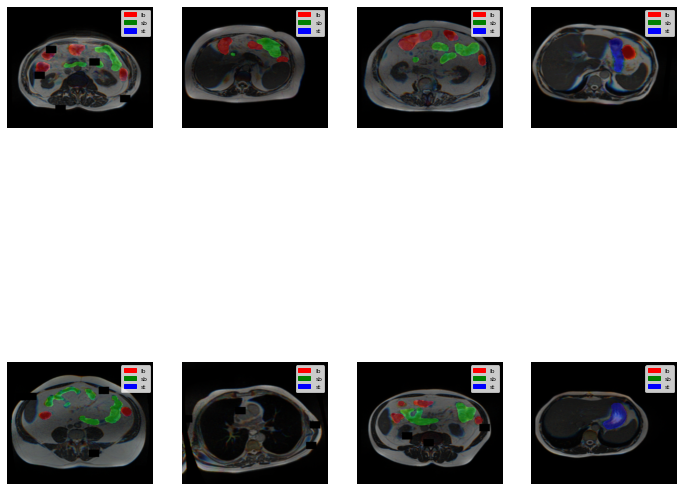

In [24]:
if not INFER:
    dls, dev = get_25D_dls(train, bs=8, img_size=(320, 384), method='squish', sample=True, sample_empty=True, show=True)

In [25]:
if not INFER:
     learn = get_custom_learner(dls, build_model('efficientnet-b0'), ComboLoss(), unet_splitter)
    # learn = get_custom_learner(dls, NestedUNet(3, 3, deep_supervision=True), deep_supervision_loss, splitter, metrics=[dice_coeff2, hd_dist2, custom_metric2])

In [26]:
# if not INFER:
#     learn = unet_learner(dls, resnet18, n_out=3, metrics=[dice_coeff, hd_dist, custom_metric], loss_func=BCEWithLogitsLossFlat()).to_fp16()

## Training

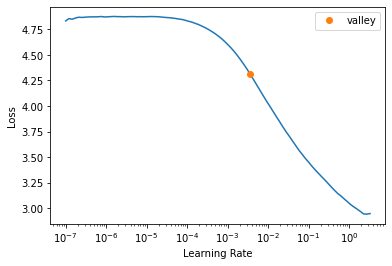

In [27]:
if not INFER:
    learn.lr_find()

In [28]:
lr = 3e-3

In [29]:
if not INFER:
    learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,dice_coeff_adj,hd_dist_adj,custom_metric_adj,time
0,1.262105,1.133513,0.299826,0.512212,0.427258,01:33
1,0.922221,0.939637,0.398315,0.596345,0.517133,01:33
2,0.753360,0.836714,0.433233,0.597325,0.531688,01:33
3,0.634912,0.776516,0.483931,0.655122,0.586646,01:32
4,0.605995,0.746442,0.504356,0.673508,0.605847,01:32


In [30]:
# if not INFER:
#     learn.unfreeze()
#     learn.fit_one_cycle(10, slice(lr/400, lr/10))

## Show Results

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


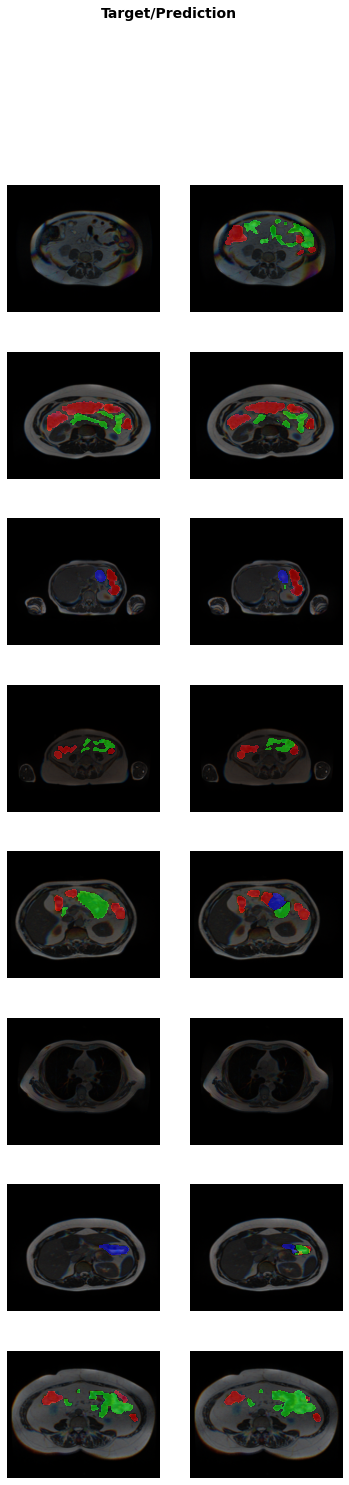

In [33]:
if not INFER:
    learn.show_results(max_n=16)

## Save Model

In [32]:
if not INFER:
    learn.export(model_name)

## Test inference 

In [24]:
if INFER:
    learn = load_learner(model_name, cpu=False)

## Visualize inference

In [25]:
if DEBUG:
    dls, dev = get_25D_dls(train, bs=8, img_size=(320, 384), method='pad', sample=True, sample_empty=True, show=False)

    raw_dl = dls.valid.new(after_item=[ToTensor], after_batch=[], bs=1)

    imgs, preds, targs = learn.get_preds(dl=dls.valid, with_input=True)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [26]:
if DEBUG:
    preds_masks = (preds > 0.5).permute(0, 2, 3, 1).cpu().detach().numpy().astype(np.uint8)

In [27]:
from tqdm import tqdm
import cv2

In [28]:
def dice_coeff_adj_pp(inp, targ):
    if torch.is_tensor(inp): inp = np.where(inp.cpu().detach().numpy() > 0.5, 1, 0)
    targ = targ.cpu().detach().numpy()
    inp = post_process(inp)
    eps = 1e-5
    dice_scores = []
    for i in range(targ.shape[0]):
        dice_i = []
        for j in range(targ.shape[1]):
            if inp[i, j].sum() == targ[i, j].sum() == 0:
                continue
            I = (targ[i, j] * inp[i, j]).sum()
            U =  targ[i, j].sum() + inp[i, j].sum()
            dice_i.append((2.*I)/(U+eps))
        if dice_i:
            dice_scores.append(np.mean(dice_i))
    
    if dice_scores:
        return np.mean(dice_scores)
    else:
        return 0

In [29]:
if DEBUG:
    before_dices = []
    after_dices = []
    org_imgs = []
    inp_masks = []
    targ_masks = []
    val = dev.query('is_valid')
    for pred_mask, pred, targ, raw_b, width, height in tqdm(zip(preds_masks, preds, targs, raw_dl, val['slice_w'], val['slice_h'])):
        upsized_mask = np.moveaxis(cv2.resize(pred_mask, dsize=(height, width), interpolation=cv2.INTER_CUBIC), -1, 0)
        targ_mask = raw_b[1]

        before_dices.append(dice_coeff_adj_pp(pred[None, ...], targ[None, ...]))
        after_dices.append(dice_coeff_adj_pp(upsized_mask[None, ...], targ_mask/255))
        org_imgs.append(raw_b[0])
        inp_masks.append(upsized_mask)
        targ_masks.append(targ_mask)

1581it [00:18, 85.61it/s] 


In [30]:
def plt_before_after(idx):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.flatten()
    
    print(before_dices[idx], after_dices[idx], val.iloc[idx]['slice_w'], val.iloc[idx]['slice_h'])
    
    # plot image and target before upsize
    decoded_small_img, decoded_small_mask = dls.decode((imgs[idx], targs[idx]))
    show_image(decoded_small_img[0], cmap='gray', ctx=axes[0])
    show_image(decoded_small_mask, cmap='Spectral_r', alpha=0.35, ctx=axes[0], title="Target (resized)")
    
    # plot image and pred before upsize
    show_image(decoded_small_img[0], cmap='gray', ctx=axes[1])
    show_image(preds_masks[idx]*255, cmap='Spectral_r', alpha=0.35, ctx=axes[1], title="Prediction (resized)")
    
    # plot image and target after upsize
    show_image(org_imgs[idx][0], cmap='gray', ctx=axes[2])
    show_image(targ_masks[idx][0], cmap='Spectral_r', alpha=0.35, ctx=axes[2], title="Target (original)")
    
    # plot image and pred after upsize
    show_image(org_imgs[idx][0], cmap='gray', ctx=axes[3])
    show_image(np.moveaxis(inp_masks[idx], 0, -1)*255, cmap='Spectral_r', alpha=0.35, ctx=axes[3], title="Prediction (upsized)")

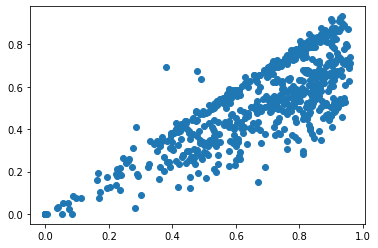

In [31]:
if DEBUG:
    diff = abs(np.array(before_dices) - np.array(after_dices))
    diff_idx_sorted = np.argsort(diff)[::-1]

    plt.scatter(before_dices, after_dices);

In [34]:
if DEBUG: print(np.mean(before_dices), np.mean(after_dices))

0.29398640482495103 0.2314874776267392


0.8121272550525831 0.28096336987618364 266 266


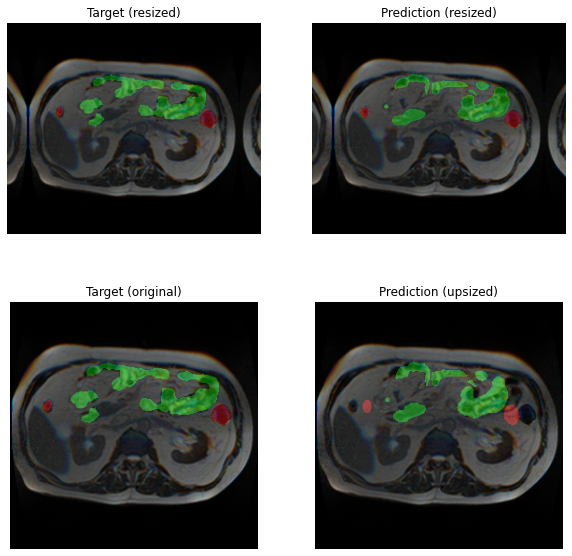

In [35]:
if DEBUG: plt_before_after(diff_idx_sorted[0])

In [40]:
def post_process(inp):
    d1, d2 = np.where(inp.sum((1, 2)) < [11, 29, 12])
    inp[d1, :, :, d2] = 0 
    return inp

In [43]:
import cv2

# Source: https://www.kaggle.com/code/clemchris/gi-seg-pytorch-train-infer

def mask2rle(mask):
    """
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    """
    mask = np.array(mask)
    pixels = mask.flatten()
    pad = np.array([0])
    pixels = np.concatenate([pad, pixels, pad])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]

    return " ".join(str(x) for x in runs)


def get_rle_masks(preds, df):
    rle_masks = []
    for pred, width, height in zip(preds, df['slice_w'], df['slice_h']):
        upsized_mask = cv2.resize(pred, dsize=(height, width), interpolation=cv2.INTER_NEAREST)
        for i in range(3):
            rle_mask = mask2rle(upsized_mask[:, :, i])
            rle_masks.append(rle_mask)
    return rle_masks

In [44]:
if INFER:
    bs = 24
    test_dl = learn.dls.test_dl(test, bs=bs, shuffle=False).to('cuda')
    b = test_dl.one_batch()

In [45]:
if INFER:
    learn.model = learn.model.cuda()
    learn.model.eval()
    masks = []
    # test_preds = np.zeros((test.shape[0], b[0].shape[2], b[0].shape[3], b[0].shape[1]), dtype=np.uint8)
    with torch.no_grad():
        for i, b in enumerate(tqdm(test_dl)):
            b[0].to('cuda')
            b_preds = (sigmoid(learn.model(b[0])[-1]) > 0.5).permute(0, 2, 3, 1).cpu().detach().numpy().astype(np.uint8)
            
            b_preds = post_process(b_preds)
            masks.extend(get_rle_masks(b_preds, test.iloc[i*bs:i*bs+bs]))
            
            # test_preds[i*bs:i*bs+bs] = b_preds
            del b_preds
            torch.cuda.empty_cache()
            gc.collect()
    
    # Post process predictions
    # test_preds = post_process(test_preds)

 13%|█▎        | 205/1604 [02:31<17:14,  1.35it/s]


KeyboardInterrupt: 

In [ ]:
# if INFER:
#     learn.model = learn.model.cuda()
#     test_dl = learn.dls.test_dl(test, shuffle=False).to('cuda')
#     test_preds = get_preds(learn, test_dl)

In [ ]:
# if INFER:
#     masks = get_rle_masks(test_preds, test)   

In [ ]:
if INFER:
    submission = pd.DataFrame({
        'id': chain.from_iterable([[get_case_id(fname)]*3 for fname in test_fnames]),
        'class': chain.from_iterable([['large_bowel', 'small_bowel', 'stomach'] for _ in test_fnames]),
        'predicted': masks,
    })
    
    if sample_submission.shape[0] > 0:
        del sample_submission['predicted']
        submission = sample_submission.merge(submission, on=['id', 'class'])
    
    submission.to_csv('submission.csv', index=False)